# Klasyfikacja obrazów za pomocą jednokierunkowej sieci neuronowej ze wsteczną propagacją
<div style="text-align: right"> Dawid Holewa </div>
Zajmiemy się znanym problemem klasyfikacji obrazów za pomocą sieci neuronowych.

### Wstęp

##### Dlaczego zagadnienie klasyfikacji obrazów jest sztandardowym przykładem problemu rozwiązywanego za pomocą sieci neuronych? 
Sieci neuronowe są przydatne wtedy, gdy nie znamy konkretnego algorytmu rozwiązania zadania, a posiadamy duży zbiór danych wraz z poprawną odpowiedzią. Klasyfikacja cyfr napisanych przez ludzi jest trudnym algorytmicznie problemem - każdy z nas ma własny kształt pisma i nie ma jednego dobrego sposobu na zapisanie znaku. Często i my mamy problem z rozczytaniem pisma innych osób. Naszą odpowiedź na pytanie o rodzaj cyfry opieramy na podstawie swoich poprzednich doświadczeń - jesteśmy w stanie stwierdzić, że znak jest bardziej podobny do jednej cyfry, niż do drugiej. W podobny sposób możemy wyuczyć program rozróżniania cyfr.

##### Technologie
Technologie, których użyjemy, by móc zaprezentować ową sieć neuronową to język programowania Python, który jest jednym z najwygodniejszych języków do uczenia maszynowego, ze względu na swój wysoki poziom abstrakcji i obfitość bibliotek przeznaczonych właśnie do tego celu. Użyjemy biblioteki Tensorflow, która stanowi najpopularniejsze środowisko uczenia głębokiego ze względu na efektywność (napisana jest w szybkim języku C) i zastosowanie wielu algorytmów optymalizujących działanie elementów składających się na sieć. Dodatkowo użyjemy interfejsu Keras, który stanowi wysoce abstrakcyjną nakładkę na bibliotekę Tensorflow, co skutecznie usprawnia szybkie pisanie sieci. Numpy pozwoli nam wstępnie przeprocesować dane, ze względu na łatwość działania na macierzach, z kolei Pandas, Seaborn i Matplotlib posłużą nam do prezentacji wyników i oceny działania sieci neuronowej    

### Przygotowanie danych
##### Pochodzenie danych
Dane, których użyjemy pochodzą z dobrze znanego zbioru amerykańskiego instytutu MNIST. Jest on na tyle popularny, że został nawet uwzględniony w Kerasie 

In [1]:
from keras.datasets import mnist
(x_train_raw, y_train), (x_test_raw, y_test) = mnist.load_data()

W bardzo wygodny sposób jesteśmy w stanie załadować dane ze zbioru MNIST. Zostały one podzielone na dwa podzbiory, dane służace trenowaniu sieci neuronowej i dane które pomogą nam zweryfikować dokładność sieci neuronowej. Oprócz tego naturalnie rozdzielamy zbiory na inputy i outputy. Przyjrzyjmy się tym danym:

In [2]:
print(f'Zbiór trenujący X - wymiary {x_train_raw.shape}')
print(f'Zbiór testujący X - wymiary {x_test_raw.shape}')

Zbiór trenujący X - wymiary (60000, 28, 28)
Zbiór testujący X - wymiary (10000, 28, 28)


In [3]:
print(f'Zbiór trenujący Y - wymiary {y_train.shape}')
print(f'Zbiór testujący Y - wymiary {y_test.shape}')

Zbiór trenujący Y - wymiary (60000,)
Zbiór testujący Y - wymiary (10000,)


Więc zbiory **X** mają wymiary _(m, n, p)_ - gdzie _m_ to liczba próbek, a _n_ i _p_ możemy potrakować jako wymiary obrazka - 28x28.

Zbiór **Y** jest wektorem liczb o długości _(m)_, które reprezentują cyfrę odpowiadającą obrazkowi

Sieci neuronowe to takie twory, które potrafią przyjąć tylko pojedyncze liczby. Jesteśmy więc zmuszeni przemodelować nasze zbiory **X**, tak aby podać pierwszej warstwie ciągi liczb. Z tego powodu spłaszczmy dwuwymiarowe obrazki do jednego wymiaru - ustawmy rząd _i_ obok rzędu _i+1_, uzyskując w ten sposób tablicę liczb o wymiarze _(1, 28*28)_ 

Każdemu pikselowi jest przyporządkowana jedna warość reprentująca odcień szarości. 
Optymalizacja bazująca na gradientach staje się stabliniejsza, gdy znormalizujemy dane. W przypadku pikseli powszechnym i skutecznym rozwiązaniem jest wyśrodkowanie i przzeskalowanie wartości z zakresy _[0,255]_ do _[-1, 1]_ <sub>przyp. [1] [4]</sub>

In [4]:
import numpy as np
def prepare_data(dataset):
    number_of_pixels = 28*28
    def reshape_data(ds):
        return ds.reshape(ds.shape[0], number_of_pixels)
    
    def normalise_pixels(matrix):
        return ((matrix / 255.) - 0.5) * 2
    
    return normalise_pixels(reshape_data(dataset))    

##### Środkowanie do średniej i normalizacja


In [5]:
def normalise_data(train, test):
    mean_values = np.mean(train, axis=0)
    std_val = np.std(train)
    def normalise_matrix(matrix):
        return (matrix - mean_values) / std_val
    return normalise_matrix(train), normalise_matrix(test)

    
x_train, x_test = normalise_data(prepare_data(x_train_raw), prepare_data(x_test_raw))

### Projektowanie modelu

##### Sieć neuronowa
Utworzymy sieć składającą się z trzech warstw, w których dwie pierwsze będą miały po 50 jednostek, a ostatnia 10 (ponieważ jest 10 cyfr w kategorayzacji. 50 jest zupełnie arbitralną liczbą, z którą można eksperymentować, tzw. hiperparametr). Funkcje aktywacji, których używamy to _tanh_ i _softmax_.

_softmax_ jest bardzo przydatną funkcją aktywacji, dzięki której 
będziemy w stanie wyliczyć prawdopodbieństwo przynalezności do danej klasy.


In [6]:
def create_model(how_many_inputs, how_many_categories):
    model = keras.models.Sequential()
    kernel_init = 'glorot_uniform'
    zeros = 'zeros'
    activation = 'tanh'
    layers = [
        keras.layers.Dense(
            units = 50,
            input_dim=how_many_inputs,
            kernel_initializer=kernel_init,
            bias_initializer=zeros,
            activation=activation
        ),
        keras.layers.Dense(
            units=50,
            input_dim=50,
            kernel_initializer=kernel_init,
            bias_initializer=zeros,
            activation=activation
        ),
        keras.layers.Dense(
            units=how_many_categories,
            input_dim=50,
            kernel_initializer=kernel_init,
            bias_initializer=zeros,
            activation='softmax'
        )
    ]
    _ = [model.add(layer) for layer in layers]
    return model

Najpierw tworzymy nowy model za pomocą _Sequential_, dzięki której inicjujemy jednokierunkową sieć neuronową. Musimy pamiętać, by warstwa wejściowa miała tyle wejść (_inputdim_), ile mamy cech (pikseli)

Musimy również pamiętać, by zapewnić tę samą liczbę jednostek wyjściowych (_units_) i wejściowych (_inputdim_) w dwóch sąsiadujących ze sobą warstwach. 

_kernelInitializer_ zainicjowaliśmy jako _glorotUniform_. Jest to zalecana metoda inicjalizacji biasów poprzez zera.

##### Dane wyjściowe
Etykiety klas (liczby [0...9]) reprezentujące liczbę znajdującą się na obrazku należy przekonwertować to znanego sposobu reprezentacji danych kategoryzowalnych. To znaczy majac _n_ etykiet klas, _i_-tą etykietę zareprezentujemy jako wektor o długości _n_ z każdym elementem równym _0_, oprócz elementu na _i_-tym indeksie, który będzie równy _1_. Dzięki temu mówimy, że poprawną etykietą będzie klasa _i_-ta, podczas gdy program będzie wypluwał _n_ prawdopodbieństw przynależności do _n_ klas


In [7]:
from keras.utils import np_utils
y_train_categorical = np_utils.to_categorical(y_train)

In [8]:
import keras
model = create_model(x_train.shape[1], y_train_categorical.shape[1])

##### Optymalizator
Wybieramy metodą **SGD** - _Stochastical Gradient Descent_, która również jest bardzo znaną metodą minimalizującą funkcję błędu. 

Jako funkcję błędu wybieramy _categorical_crossentropy_, która świetnie się sprawdza z danymi kategoryzowalnymi. Entropia krzyżowa (=binarna) jest to funkcja kosztu w modelu regresji logistycznej, a entropia kategoryzująca to jej uogólnienie na wieloklasowego prognozownia za pomocą algoeytmu softmax. 

Dodatkowo, możemy eksperymentować z _learning_rate_, _momentum_ i _decay_, które również są hiperparametrami. 

In [9]:
import tensorflow.keras.optimizers as optimisers
sgd_optimizer = optimisers.SGD(
    learning_rate=0.001, decay=1e-7, momentum=0.9
)

In [10]:
model.compile(optimizer=sgd_optimizer, loss='categorical_crossentropy')

Po skompilowaniu modelu możemy go wytrenować przy pomocy metody _fit_. Metoda stochastycznego gradientu bazuje na podzbiorach naszych danych, które składają się z 64 próbek (_batch_size_) na każdą z minipaczek (jest to kolejny sposób na optymalizację sieci). 
Model składa się z 50 epok, po każdej będziemy mogli zobaczyć jak radzi sobie funkcja kosztu dzięki _verbose=1_. 
Dzięki ustawieniu _validation_split=0.1_ rezerwujemy około 10% danych uczących na walidację modelu po każdej epoce. Obliczany jest wtedy _val_loss_ dzięki naszej funkcji kosztu na _walidacyjnym_ podzbiorze zbioru trenującego. 
Po każdej epoce możemy wywołać pewne callbacki, my decydujemy się na zastosowanie _EarlyStopping_, który zakończy trenowanie wtedy, gdy parametr _val_loss_ po 3 iteracjach przestanie się poprawiać. Dzięki temu będziemy mogli uniknąć przetrenowania.     

In [11]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=3, verbose=1)

In [12]:
history = model.fit(x_train, 
                    y_train_categorical, 
                    batch_size=64, 
                    epochs=50, 
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[es]
                   )

Epoch 1/50
844/844 [==============================] - 3s 3ms/step - loss: 0.7469 - val_loss: 0.3687
Epoch 2/50
844/844 [==============================] - 2s 2ms/step - loss: 0.3749 - val_loss: 0.2794
Epoch 3/50
844/844 [==============================] - 2s 2ms/step - loss: 0.3070 - val_loss: 0.2422
Epoch 4/50
844/844 [==============================] - 2s 2ms/step - loss: 0.2705 - val_loss: 0.2195
Epoch 5/50
844/844 [==============================] - 2s 2ms/step - loss: 0.2452 - val_loss: 0.2040
Epoch 6/50
844/844 [==============================] - 3s 3ms/step - loss: 0.2257 - val_loss: 0.1909
Epoch 7/50
844/844 [==============================] - 1s 2ms/step - loss: 0.2096 - val_loss: 0.1806
Epoch 8/50
844/844 [==============================] - 2s 3ms/step - loss: 0.1960 - val_loss: 0.1718
Epoch 9/50
844/844 [==============================] - 3s 3ms/step - loss: 0.1842 - val_loss: 0.1657
Epoch 10/50
844/844 [==============================] - 2s 2ms/step - loss: 0.1739 - val_loss: 0.1588

### Wyniki
Dzięki modelowi przewidujemy wyniki dla zbioru testowego. _argmax_ z flagą _axis=1_ zapewni nam indeks największej wartości na osi y, czyli liczbę, o której model myśli, że jest najbardziej zbliżona do obrazu.

In [13]:
y_prediction = np.argmax(model.predict(x_test), axis=1)

Zobaczmy najpierw, jak prezentuje się wykres funkcji błędu ze względu na epoki na danych trenujących i walidacyjnych. Zatrzymaliśmy się troszkę wcześniej na trenowaniu - widzimy, że wykres walidacyjny przestaje się poprawiać w pewnym momencie. Dzięki temu uniknamy przetrenowania.

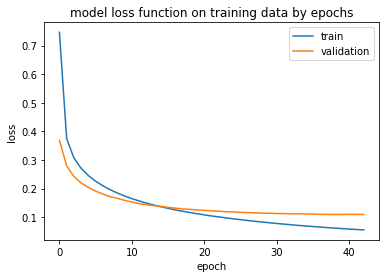

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('model loss function on training data by epochs')
plt.legend(['train', 'validation'])
plt.show()

In [29]:
print(f"Loss: {history.history['loss'][-1]}")
print(f"Validation loss: {history.history['val_loss'][-1]}")

Loss: 0.05529918149113655
Validation loss: 0.109440878033638


W celu lepszego rozeznania co do sprawności modelu popatrzmy na confusion matrix:

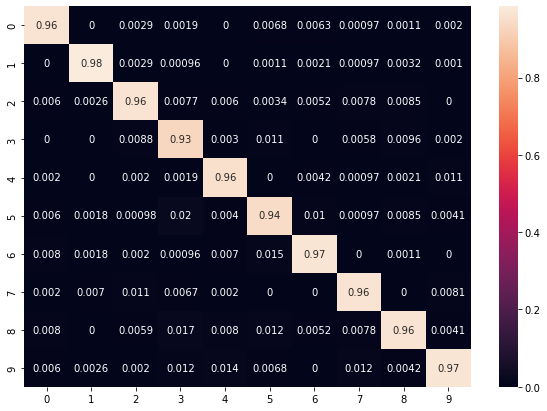

In [14]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
cfm = confusion_matrix(y_test, y_prediction, normalize='pred')
df_cm = pd.DataFrame(cfm, index = range(10), 
                     columns = range(10))
plt.figure(figsize = (10, 7))
sn.heatmap(df_cm, annot=True)
plt.show()

Czytamy go tak:
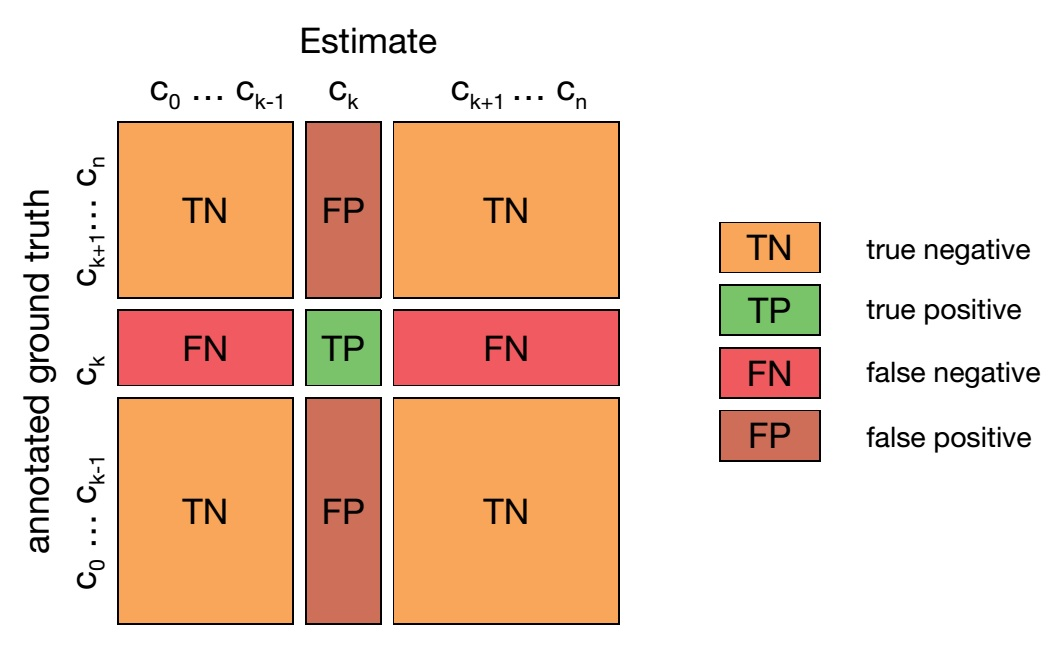
Więc patrząc na przekątne możemy powiedzieć, że nasz model bardzo dobrze sobie radzi z klasyfikacją - sprawność mieści się w przedziale [93, 96] %. Analizując macierz możemy wyciągnąć wiele wniosków - np. największy problem model ma z cyfrą 3, a najbardziej myli trojkę z ósemką.

Ostatnie, czym się zajmiemy to metryki. <br/>
Precision = _TP/(TP+FP)_ <br/>
Recall = _TP/(TP+FN)_ <br/>
F1 = _2/((1/PRECISION)+(1/RECALL))_ <br/>

Precision - ile ze wszystkich pozytywnych wyników jest prawdziwie pozytywna.
Recall - ile wyników poprawnie określa klasę ze wszystkich wyników, w których ta klasa występuje
F1 - średnia harmoniczna recall i precision. 

In [43]:
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score
mode = 'macro'
print(f'precision: {precision_score(y_test, y_prediction, average=mode)}')
print(f'recall: {recall_score(y_test, y_prediction, average=mode)}')
print(f'f1: {f1_score(y_test, y_prediction, average=mode)}')

accuracy: 0.9601
precision: 0.9597342191325604
recall: 0.9594756463059385
f1: 0.9595158570138024


### Bibliografia
[1] https://qa-stack.pl/stats/7757/data-normalization-and-standardization-in-neural-networks

[2] https://keras.io/api/metrics/

[3] https://gist.github.com/Orbifold/b31265032d001646370cc9306cf4ca6d

[4] Python. Uczenie maszynowe. https://lubimyczytac.pl/ksiazka/4842903/python-uczenie-maszynowe

[5] https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/